In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/14986.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/3138.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/1700.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/16257.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/2863.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/771.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/12167.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/17643.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/6560.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/10162.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/4009.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/15823.jpg
/kaggle/input/intel-image-classification/seg_tr

# Load data

In [2]:
# Imports
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells

In [3]:
# Load training and validation sets
ds_train_ = image_dataset_from_directory(
    '../input/intel-image-classification/seg_train/seg_train',
    image_size=[128, 128],
    batch_size=64,
    shuffle=True,
    label_mode='categorical'
)
ds_test_ = image_dataset_from_directory(
    '../input/intel-image-classification/seg_test/seg_test',
    image_size=[128, 128],
    batch_size=64,
    shuffle=True,
    label_mode='categorical'
)

Found 14034 files belonging to 6 classes.


2022-06-29 15:04:59.956928: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-29 15:05:00.098451: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-29 15:05:00.099371: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-29 15:05:00.103049: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Found 3000 files belonging to 6 classes.


In [4]:
# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_test = (
    ds_test_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)


# Step 2 - Define Model

# Model1 :basic model

In [5]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
model1 = keras.Sequential([
    layers.Conv2D(32, (3,3), activation="relu", padding='same',input_shape =[128,128,3]),
    layers.MaxPool2D(),
    layers.Conv2D(32, (3,3), activation="relu", padding='same'),
    layers.MaxPool2D(),
    layers.Flatten(),
    layers.Dense(units=64, activation="relu"),
    layers.Dense(units=6, activation="softmax")
])


In [6]:
model1.compile(
    optimizer= 'adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
history1 = model1.fit(
    ds_train,
    validation_data = ds_test,
    epochs=30,
    verbose=0,
)

2022-06-29 15:05:04.078706: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-06-29 15:05:06.552806: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


<AxesSubplot:>

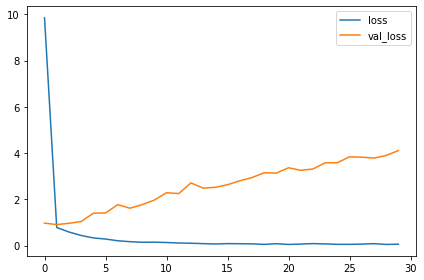

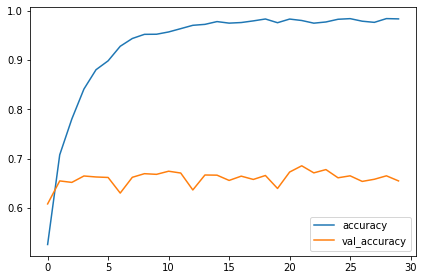

In [7]:
import pandas as pd

history1_frame = pd.DataFrame(history1.history)
history1_frame.loc[:, ['loss', 'val_loss']].plot()
history1_frame.loc[:, ['accuracy', 'val_accuracy']].plot()

# Model2 tuning basic model
data augmentation+dropout layers

In [8]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental import preprocessing
model2 = keras.Sequential([
    # Preprocessing
    preprocessing.RandomFlip('horizontal'), # flip left-to-right
    preprocessing.RandomContrast(0.5),
    layers.Conv2D(32, (3,3), activation="relu", padding='same',input_shape =[128,128,3]),
    layers.MaxPool2D(),
    layers.Dropout(rate=0.3),
    layers.Conv2D(32, (3,3), activation="relu", padding='same'),
    layers.MaxPool2D(),
    layers.Dropout(rate=0.3),
    layers.Flatten(),
    layers.Dense(units=64, activation="relu"),
    layers.Dense(units=6, activation="softmax")
])
model2.compile(
    optimizer= 'adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
history2 = model2.fit(
    ds_train,
    validation_data = ds_test,
    epochs=30,
    verbose=0,
)

<AxesSubplot:>

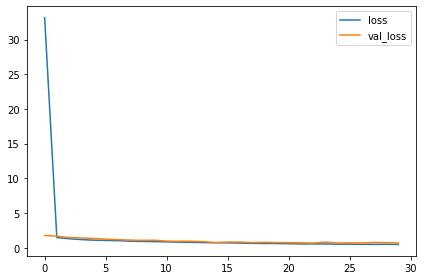

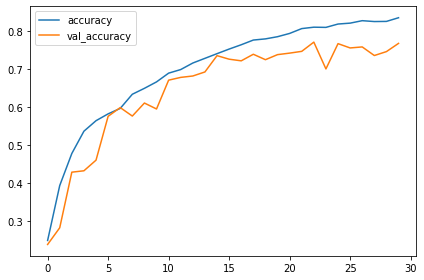

In [9]:
import pandas as pd

history2_frame = pd.DataFrame(history2.history)
history2_frame.loc[:, ['loss', 'val_loss']].plot()
history2_frame.loc[:, ['accuracy', 'val_accuracy']].plot()

# Model3
transfer learning model:VGG16

In [10]:
from tensorflow.keras import applications
VGG16_MODEL=tf.keras.applications.VGG16(input_shape=[128,128,3],
                                               include_top=False,
                                               weights='imagenet')
VGG16_MODEL.trainable=False

58900480/58889256 [==============================] - 0s 0us/step


In [11]:
model3 = keras.Sequential([
    # Preprocessing
    preprocessing.RandomFlip('horizontal'), # flip left-to-right
    preprocessing.RandomContrast(0.5),
    VGG16_MODEL,
    layers.Flatten(),
    layers.Dense(units=64, activation="relu"),
    layers.Dense(units=6, activation="softmax")
])
model3.compile(
    optimizer= 'adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
history3 = model3.fit(
    ds_train,
    validation_data = ds_test,
    epochs=30,
    verbose=0,
)

<AxesSubplot:>

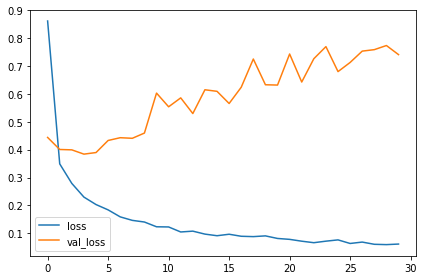

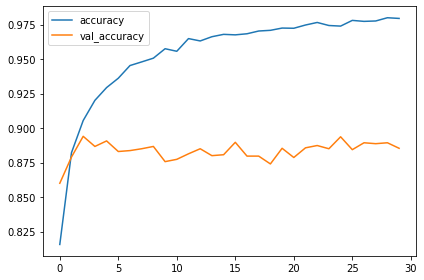

In [12]:
import pandas as pd

history3_frame = pd.DataFrame(history3.history)
history3_frame.loc[:, ['loss', 'val_loss']].plot()
history3_frame.loc[:, ['accuracy', 'val_accuracy']].plot()

#Model4
tuning model3 model

In [13]:
model4 = keras.Sequential([
    # Preprocessing
    preprocessing.RandomFlip('horizontal'), # flip left-to-right
    preprocessing.RandomContrast(0.5),
    VGG16_MODEL,
    layers.Flatten(),
    layers.Dense(units=64, activation="relu"),
    layers.Dropout(rate=0.3),
    layers.Dense(units=6, activation="softmax")
])
model4.compile(
    optimizer= 'adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
history4 = model4.fit(
    ds_train,
    validation_data = ds_test,
    epochs=30,
    verbose=0,
)

<AxesSubplot:>

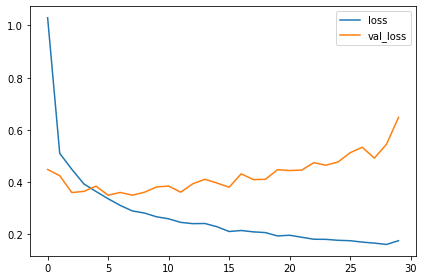

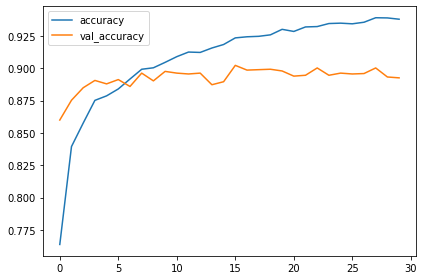

In [14]:
import pandas as pd

history4_frame = pd.DataFrame(history4.history)
history4_frame.loc[:, ['loss', 'val_loss']].plot()
history4_frame.loc[:, ['accuracy', 'val_accuracy']].plot()

# Model5
improve dropout

In [15]:
model5 = keras.Sequential([
    # Preprocessing
    preprocessing.RandomFlip('horizontal'), # flip left-to-right
    preprocessing.RandomContrast(0.5),
    VGG16_MODEL,
    layers.Flatten(),
    layers.Dense(units=64, activation="relu"),
    layers.Dropout(rate=0.5),
    layers.Dense(units=6, activation="softmax")
])
model5.compile(
    optimizer= 'adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
history5 = model5.fit(
    ds_train,
    validation_data = ds_test,
    epochs=30,
    verbose=0,
)

<AxesSubplot:>

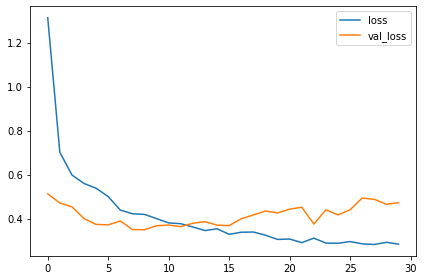

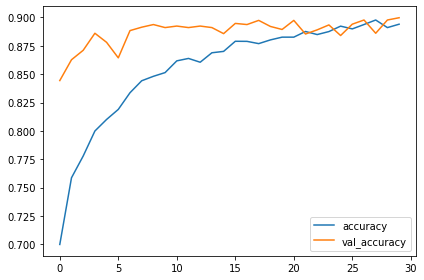

In [16]:
import pandas as pd

history5_frame = pd.DataFrame(history5.history)
history5_frame.loc[:, ['loss', 'val_loss']].plot()
history5_frame.loc[:, ['accuracy', 'val_accuracy']].plot()

# Model6

In [17]:
model6 = keras.Sequential([
    # Preprocessing
    preprocessing.RandomFlip('horizontal'), # flip left-to-right
    preprocessing.RandomContrast(0.5),
    VGG16_MODEL,
    layers.Flatten(),
    layers.Dense(units=64, activation="relu"),
    layers.BatchNormalization(),
    layers.Dense(units=6, activation="softmax")
])
model6.compile(
    optimizer= 'adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
history6 = model6.fit(
    ds_train,
    validation_data = ds_test,
    epochs=30,
    verbose=0,
)

<AxesSubplot:>

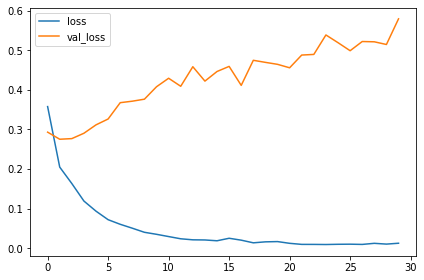

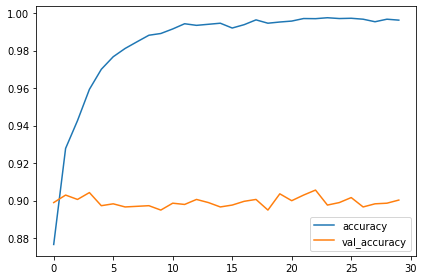

In [18]:
import pandas as pd

history6_frame = pd.DataFrame(history6.history)
history6_frame.loc[:, ['loss', 'val_loss']].plot()
history6_frame.loc[:, ['accuracy', 'val_accuracy']].plot()

# 3.Compare all models

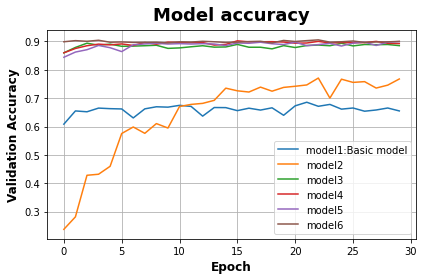

In [19]:
plt.plot(history1.history['val_accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.plot(history5.history['val_accuracy'])
plt.plot(history6.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Validation Accuracy')
plt.xlabel('Epoch')
plt.legend(['model1:Basic model', 'model2', 'model3', 'model4', 'model5','model6'], loc='lower right')
plt.grid(True)
plt.show()

Compare different methods:dropout(0.3) vs dropout(0.5) vs batch normalization
Accuracy

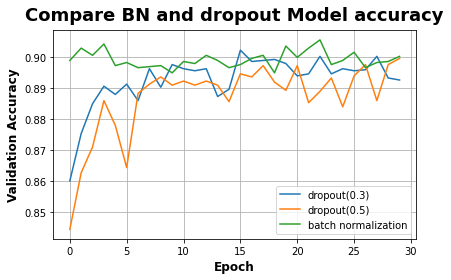

In [20]:
plt.plot(history4.history['val_accuracy'])
plt.plot(history5.history['val_accuracy'])
plt.plot(history6.history['val_accuracy'])
plt.title('Compare BN and dropout Model accuracy')
plt.ylabel('Validation Accuracy')
plt.xlabel('Epoch')
plt.legend(['dropout(0.3)', 'dropout(0.5)','batch normalization'], loc='lower right')
plt.grid(True)
plt.show()

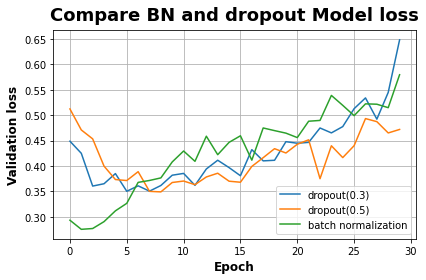

In [21]:
plt.plot(history4.history['val_loss'])
plt.plot(history5.history['val_loss'])
plt.plot(history6.history['val_loss'])
plt.title('Compare BN and dropout Model loss')
plt.ylabel('Validation loss')
plt.xlabel('Epoch')
plt.legend(['dropout(0.3)', 'dropout(0.5)','batch normalization'], loc='lower right')
plt.grid(True)
plt.show()